In [1]:
%matplotlib notebook
import os
import numpy as np
from glob import glob
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

from inference import iFCN

# model 
backbone_name = 'ResNet50'
stride_out = 8
upsample_type = 'deconv'
weights_path = './models/ResNet50_8s_deconv/2021-08-11 01-41-10.746391_best_mean_iou.pkl'
num_device = 1
mask_threshold = 0.5

# image path
image_suffix = '.jpg'
to_be_predicted_image_dir = './images'
save_image_dir = './result'


    Usage:
        mouse: 
            left button: foreground interaction
            right button: background interaction
        keyboard:
            key 'ctrl + alt + s': save predict result
            key 'n': next image
            key 'p': previous image

1 to be predicted.


<IPython.core.display.Javascript object>


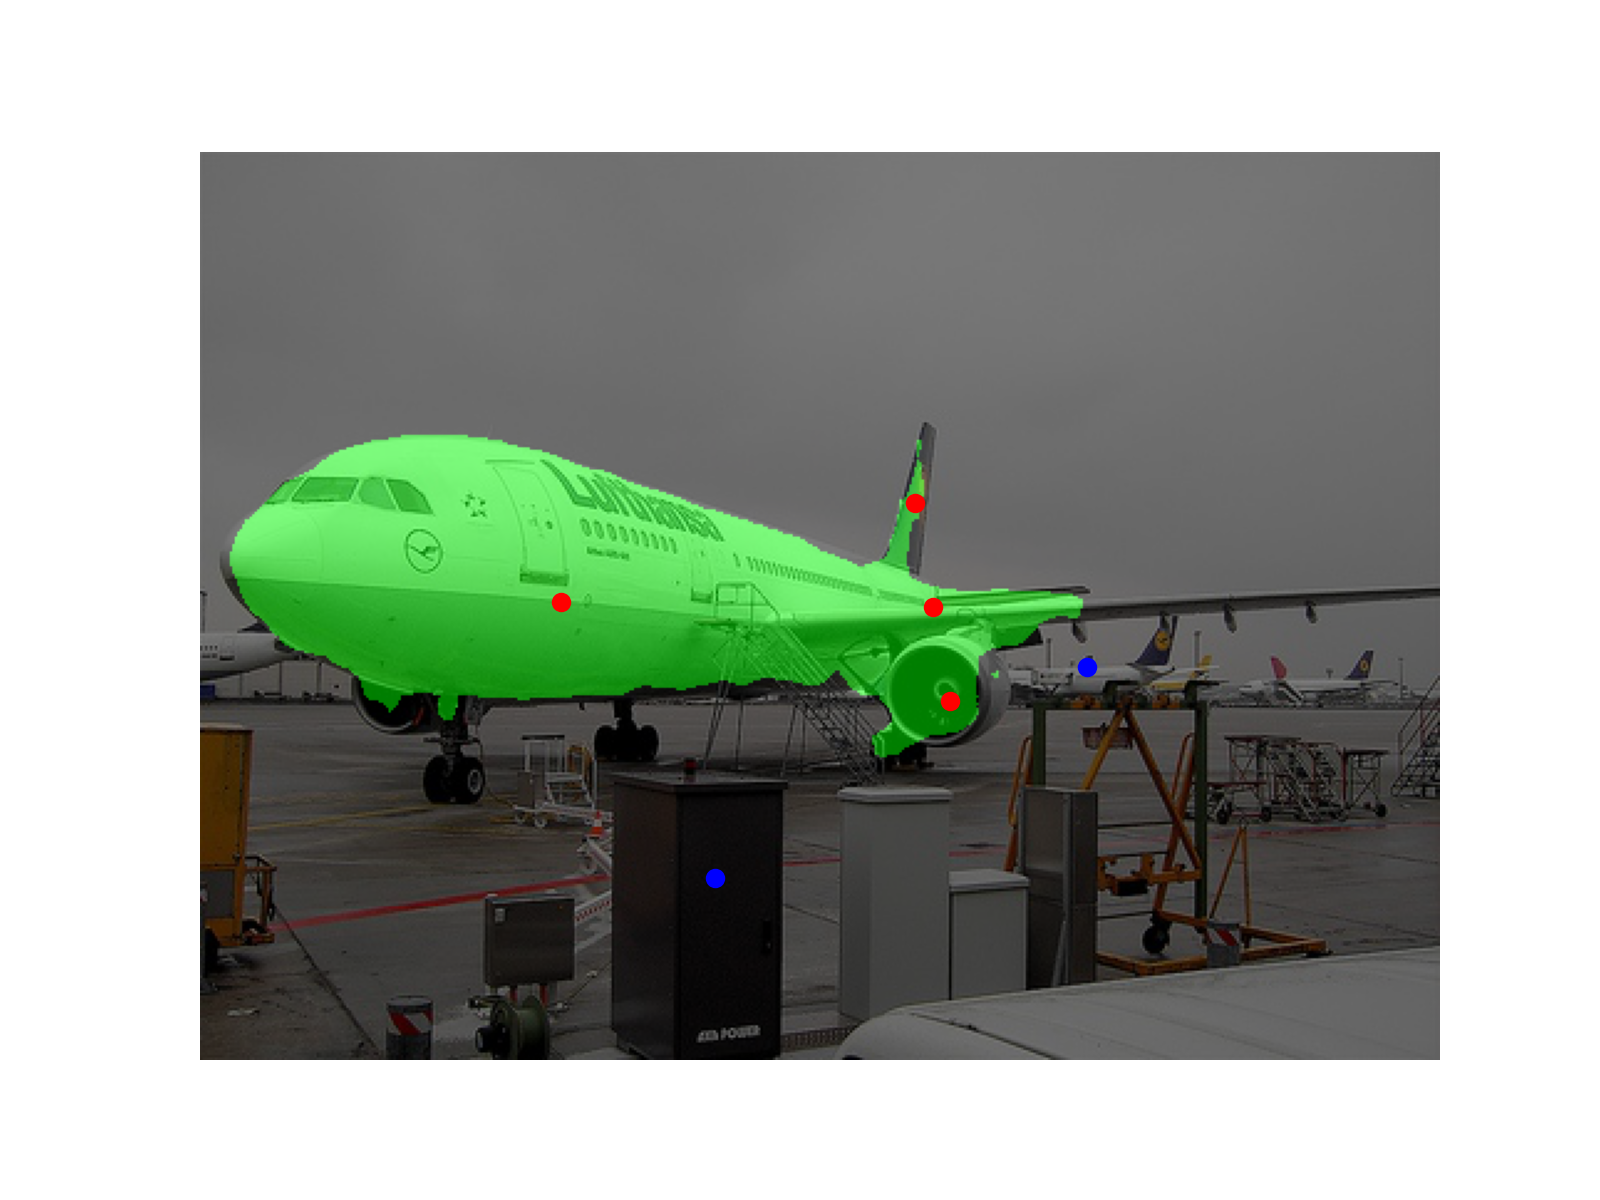

Interactive Image Segmentation


In [2]:
%matplotlib notebook

print("""
    Usage:
        mouse: 
            left button: foreground interaction
            right button: background interaction
        keyboard:
            key 'ctrl + alt + s': save predict result
            key 'n': next image
            key 'p': previous image
""")

net = iFCN(backbone_name, stride_out, upsample_type, weights_path, num_device, mask_threshold)
image_paths = glob(os.path.join(to_be_predicted_image_dir, f'*{image_suffix}'))
print(f'{len(image_paths)} to be predicted.')
cur_image_index = 0
result = None
points_list = []
# color_map = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]
interactives_color_map = ['r', 'b'] # fg, bg
result_mask_color = [0, 255, 0]
fig = plt.figure("Interactive Image Segmentation", figsize=(8, 6))
cur_source_image = np.array(Image.open(image_paths[cur_image_index]))
plt.imshow(cur_source_image)
plt.axis("off")
plt.show()

def point_list_to_interactives_map(points_list, image_size):
    # image_size: (h, w)
    h, w = image_size
    interactives_map = np.zeros((2, h, w))
    for point in points_list:
        x, y, i = point
        interactives_map[i, y, x] = 1
    return interactives_map

def refresh():
    global fig, cur_source_image, result, points_list, interactives_color_map
    plt.cla()
    plt.imshow(cur_source_image)
    plt.axis("off")
    if result is not None:
        show_result = np.zeros_like(cur_source_image)
        show_result[result == 1] = result_mask_color
        plt.imshow(show_result, alpha=0.5)
    for point in points_list:
        x, y, i = point
        plt.scatter(x, y, c=interactives_color_map[i])
    fig.canvas.draw()

def mouse_press(event):
    global fig, points_list, cur_source_image, result, color_map, hold_press_ctrl_key
    cur_num_points = len(points_list)
    if event.button == 1 or event.button == 3:  
        points_list.append([int(event.xdata), int(event.ydata), event.button//3])
        plt.scatter(int(event.xdata), int(event.ydata), c=interactives_color_map[event.button//3])
        fig.canvas.draw()
    
    num_points = len(points_list)
    if cur_num_points != num_points:
        if num_points > 0:
            plt.title('predicting...')
            interactives_map = point_list_to_interactives_map(points_list, cur_source_image.shape[:2])
            result = net.predict(cur_source_image, interactives_map[0], interactives_map[1])
        else:
            result = None
        refresh()

def key_press(event):
    global fig, points_list, save_image_dir, cur_source_image, cur_image_index, image_paths, result
    if event.key == 'ctrl+alt+s': # 保存
        if result is not None:
            image_name = os.path.splitext(os.path.split(image_paths[cur_image_index])[1])[0]
            if not os.path.exists(save_image_dir):
                os.mkdir(save_image_dir)
            time_str = datetime.now().__str__().replace(':', '-').replace(' ','_')
            plt.title(f"")
            plt.savefig(os.path.join(save_image_dir, f'{image_name}_{time_str}_fig.png'))
            plt.imsave(os.path.join(save_image_dir, f'{image_name}_{time_str}_mask.png'), result)
            plt.title(f"saved.")
    elif event.key == 'c':
        if len(points_list) - 1 >= 0:
            del points_list[-1]
            if len(points_list) > 0:
                interactives_map = point_list_to_interactives_map(points_list, cur_source_image.shape[:2])
                result = net.predict(cur_source_image, interactives_map[0], interactives_map[1])
            else:
                result = None
            refresh()
    elif event.key == 'n':
        if cur_image_index + 1 >= len(image_paths):
            cur_image_index = 0
        else:
            cur_image_index += 1
        cur_source_image = np.array(Image.open(image_paths[cur_image_index]))
        refresh()
    elif event.key == 'p':
        if cur_image_index - 1 < 0:
            cur_image_index = len(image_paths) - 1
        else:
            cur_image_index -= 1
        cur_source_image = np.array(Image.open(image_paths[cur_image_index]))
        refresh()

fig.canvas.mpl_connect("button_press_event", mouse_press)
fig.canvas.mpl_connect("key_press_event", key_press)
print("Interactive Image Segmentation")